In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from sklearn.metrics import *
from tqdm import tqdm
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
TRAIN_PATH = 'train/'

X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

In [3]:
TEST_PATH = 'test/'

In [4]:
X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

In [5]:
def make_X3_PCA(X3, n_components=20):    
    X3_data = X3.drop(['id'], axis=1)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X3_data)
    X3_PCA = pd.DataFrame(data = principalComponents)
    print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))
    X3_PCA.columns = ['x3_'+str(x) for x in range(1,n_components+1)]
    X3_PCA['id'] = X3['id']
    return X3_PCA

In [6]:
X3_train_PCA = make_X3_PCA(X3)
X3_test_PCA = make_X3_PCA(X3_test)
X3_test_PCA.head()

[0.16294211 0.07510154 0.05892131 0.04532894 0.03367757 0.02773395
 0.02532202 0.02390905 0.02092659 0.01877066 0.01758252 0.01711394
 0.01504836 0.01416037 0.013183   0.01281071 0.01219151 0.01173914
 0.01096741 0.01015993] 0.6275906195341778
[0.16135396 0.07218593 0.0602042  0.04881525 0.04399043 0.03504773
 0.02858463 0.02489501 0.02344016 0.02102328 0.01928419 0.01865373
 0.01711468 0.01474555 0.01433851 0.01197679 0.01162697 0.01144779
 0.0110493  0.01071473] 0.6604928152847847


,x3_1,x3_2,x3_3,x3_4,x3_5,x3_6,x3_7,x3_8,x3_9,x3_10,x3_11,x3_12,x3_13,x3_14,x3_15,x3_16,x3_17,x3_18,x3_19,x3_20,id
0,-0.074568,0.009804,-0.026766,-0.042508,0.049833,-0.032029,0.017017,0.076153,0.000155,0.061230,-0.000364,0.098826,-0.018569,0.038366,-0.030414,0.008530,0.029001,0.015946,-0.051193,-0.006130,0
1,-0.137236,0.085437,0.048334,0.023199,0.013082,0.011140,0.006342,-0.017034,0.001729,0.008694,-0.033004,-0.002661,0.017431,0.012660,-0.015868,0.008278,0.014183,-0.008039,-0.030921,-0.040420,1
2,0.007605,0.015442,-0.051487,0.021782,-0.048599,0.035924,-0.024044,0.014926,0.000833,-0.001381,0.002330,-0.007054,-0.006220,-0.032460,-0.009430,0.016977,0.032453,-0.014094,-0.001403,-0.015086,2
3,-0.130075,-0.044762,-0.069831,-0.057599,0.050444,-0.086707,-0.016564,0.090821,0.272710,0.257091,0.092983,0.127523,-0.105311,0.081762,-0.046764,-0.054091,0.137700,0.034288,0.200216,-0.059205,4
4,-0.131870,-0.025732,0.017662,0.050416,-0.035888,-0.026611,-0.060175,-0.075400,-0.030455,0.018136,-0.062667,-0.011877,-0.066316,0.008626,-0.036978,-0.017209,0.014765,-0.003646,0.095547,0.010167,7


In [7]:
def prepare_X1(X1):
    data = X1

    bin_cols = []
    cat_cols = []
    num_cols = []

    for c in X1.columns:
        if c == 'id':
            continue        
        unique_vals = len(data[c].unique())
        #print(c, unique_vals)

        if unique_vals == 2:
            bin_cols.append(c)
        elif unique_vals > 2 and unique_vals < 10:
            cat_cols.append(c)
        else:
            num_cols.append(c)
            
    print('bin cols:', len(bin_cols), bin_cols)
    print('cat cols:', len(cat_cols), cat_cols)
    print('num cols:', len(num_cols), num_cols)
    
    data[cat_cols] = data[cat_cols].astype('category')
    
    # преобразование категориальных признаков в бинарные (dummy)
    data_categorical = pd.get_dummies(data[cat_cols])
    
    # нормализация значений количественных признаков
    data_numerical = data[num_cols]
    data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
    data_numerical.describe()
    
    # объединяем все признаки в единый DataFrame
    data = pd.concat((data_numerical, data[bin_cols], data_categorical), axis=1)
    data = pd.DataFrame(data, dtype=float)
    
    x1_col_count = len(data.columns)
    data.columns = ['x1_'+str(x) for x in range(1, x1_col_count+1)]
    
    data['id'] = X1['id']
    return data

In [8]:
X1_train_prep = prepare_X1(X1)
X1_test_prep = prepare_X1(X1_test)
X1_train_prep.head()

bin cols: 17 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
cat cols: 2 ['2', '3']
num cols: 6 ['4', '5', '6', '7', '8', '9']
bin cols: 17 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
cat cols: 2 ['2', '3']
num cols: 6 ['4', '5', '6', '7', '8', '9']


,x1_1,x1_2,x1_3,x1_4,x1_5,x1_6,x1_7,x1_8,x1_9,x1_10,x1_11,x1_12,x1_13,x1_14,x1_15,x1_16,x1_17,x1_18,x1_19,x1_20,x1_21,x1_22,x1_23,x1_24,x1_25,x1_26,x1_27,x1_28,x1_29,x1_30,x1_31,x1_32,x1_33,id
0,0.012128,0.114718,0.630345,0.031442,-0.404751,-0.106410,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
1,-0.230146,-0.299019,-0.059385,-0.116326,-0.524259,-0.033508,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
2,0.154151,-0.047532,5.679800,-0.083489,0.917306,0.950677,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6
3,-0.001795,0.257497,0.242989,-0.132744,-0.531728,-0.033508,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8
4,-0.283057,-0.297396,-0.365712,-0.132744,-0.404751,-0.069959,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10


In [9]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    sparse_matrix = np.zeros((len(rows), len(cols)), dtype = np.uint8)

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, selected_cols]

    sns.distplot(trimmed_sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        svd = TruncatedSVD(n_components=150)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    
    x2_col_count = len(components.columns)
    components.columns = ['x2_'+str(x) for x in range(1, x2_col_count+1)]
    
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    
    return X2, svd

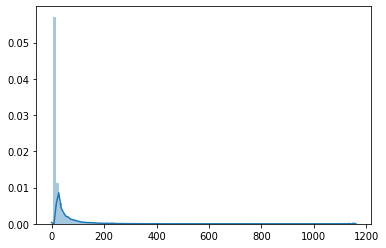

In [10]:
X2_all = X2.append(X2_test)
X2_all, svd = transform_x2(X2_all)

In [11]:
print(X2_all.shape)
X2_all.head()

(8058, 151)


,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_8,x2_9,x2_10,x2_11,x2_12,x2_13,x2_14,x2_15,x2_16,x2_17,x2_18,x2_19,x2_20,x2_21,x2_22,x2_23,x2_24,x2_25,x2_26,x2_27,x2_28,x2_29,x2_30,x2_31,x2_32,x2_33,x2_34,x2_35,x2_36,x2_37,x2_38,x2_39,x2_40,x2_41,x2_42,x2_43,x2_44,x2_45,x2_46,x2_47,x2_48,x2_49,x2_50,x2_51,x2_52,x2_53,x2_54,x2_55,x2_56,x2_57,x2_58,x2_59,x2_60,x2_61,x2_62,x2_63,x2_64,x2_65,x2_66,x2_67,x2_68,x2_69,x2_70,x2_71,x2_72,x2_73,x2_74,x2_75,x2_76,x2_77,x2_78,x2_79,x2_80,x2_81,x2_82,x2_83,x2_84,x2_85,x2_86,x2_87,x2_88,x2_89,x2_90,x2_91,x2_92,x2_93,x2_94,x2_95,x2_96,x2_97,x2_98,x2_99,x2_100,x2_101,x2_102,x2_103,x2_104,x2_105,x2_106,x2_107,x2_108,x2_109,x2_110,x2_111,x2_112,x2_113,x2_114,x2_115,x2_116,x2_117,x2_118,x2_119,x2_120,x2_121,x2_122,x2_123,x2_124,x2_125,x2_126,x2_127,x2_128,x2_129,x2_130,x2_131,x2_132,x2_133,x2_134,x2_135,x2_136,x2_137,x2_138,x2_139,x2_140,x2_141,x2_142,x2_143,x2_144,x2_145,x2_146,x2_147,x2_148,x2_149,x2_150,id
0,0.020328,-0.030088,0.001304,0.030721,-0.005557,0.027775,0.014473,-0.005130,0.019801,-0.000167,-0.042056,0.018991,0.002140,-0.002934,-0.025256,0.021591,0.013164,-0.012012,0.011445,0.016007,0.011732,0.003674,0.003390,0.031410,0.004039,0.013982,-0.008547,0.008381,-0.034072,-0.016244,0.019013,0.001048,-0.010552,0.012218,-0.007698,-0.000037,0.026135,0.009344,0.004908,-0.000518,-0.010888,-0.009169,-0.007678,0.016858,0.004941,0.016519,0.016010,-0.005438,0.009891,-0.016242,-0.015316,-0.002619,0.004440,-0.025327,0.000025,-0.015983,0.008527,-0.014346,0.036716,0.012782,-0.005263,-0.006837,-0.009468,-0.016026,-0.004462,0.000868,-0.001791,-0.001333,0.016385,0.026183,-0.023235,-0.002674,0.019280,-0.023353,0.003751,0.014836,0.001132,0.020242,0.021955,0.002213,-0.015224,0.001792,-0.000277,-0.011045,-0.021183,-0.031262,0.000146,-0.019583,0.049536,0.000539,0.034857,-0.006920,0.003380,0.000569,-0.020149,0.026037,0.014232,-0.004332,0.017085,0.018206,0.011296,0.002214,-0.021892,0.003319,0.008743,0.005059,-0.024106,0.003054,0.004231,-0.017239,0.017674,0.004541,0.016215,0.000115,0.017216,0.028608,-0.002131,-0.003036,-0.003439,-0.031763,-0.013768,0.001113,0.023735,-0.005923,0.011757,-0.012515,0.010616,-0.004336,-0.015531,0.003627,-0.028946,-0.012403,-0.019158,-0.008626,-0.006076,0.005362,0.009446,0.002355,-0.010196,-0.024958,-0.003564,-0.004554,0.000755,0.017020,0.010127,-0.005688,-0.029472,0.039661,0.008286,0.008089,3
1,0.675744,-0.575195,0.553218,-0.007557,-0.273041,0.041558,0.852531,-0.228584,-0.612160,0.271046,-0.210099,0.553381,0.054009,0.135574,0.374473,0.076861,0.224698,0.254275,0.537639,0.190232,0.211299,0.164026,-0.010197,0.465156,-0.051720,0.019378,-0.110566,0.079794,0.023181,-0.031043,0.131903,-0.019767,0.121093,-0.108544,0.162036,-0.077589,-0.205722,0.090100,0.364821,0.225909,0.079504,-0.064634,0.033812,0.021351,-0.174386,-0.014203,0.053737,0.055802,-0.012444,-0.142709,-0.080425,-0.174284,0.092173,-0.204517,-0.126119,-0.252292,-0.058944,-0.177282,0.193874,-0.057486,0.129476,-0.202413,-0.147278,-0.002505,-0.078688,0.006563,0.102879,-0.115047,0.232952,0.132627,0.012161,-0.102978,0.150237,0.084243,0.070766,0.132719,0.067681,0.061746,0.149403,-0.184187,-0.002751,-0.029495,0.017270,0.059663,0.241014,-0.135703,0.050372,0.123321,0.073623,0.160960,0.116519,0.047177,-0.054423,0.019057,-0.130610,0.119374,0.200245,-0.163762,0.054594,-0.136757,0.056174,-0.091241,-0.318855,0.059388,0.272411,-0.249015,-0.244941,0.026222,0.018139,-0.005396,-0.158166,-0.209973,-0.146027,0.079632,0.187137,0.163737,-0.073028,0.233758,-0.154371,-0.238305,-0.152457,-0.066133,0.095068,0.147055,0.125130,-0.043563,0.248917,-0.023527,0.171246,-0.123581,0.215596,-0.063316,-0.038885,-0.079369,-0.001472,0.151696,-0.291007,-0.144561,0.083258,0.084100,0.054984,-0.129657,0.079271,-0.002987,0.490191,-0.147736,0.071372,-0.150748,0.078081,0.255795,5
2,0.037604,-0.038847,0.035745,-0.013337,-0.034465,-0.006691,0.072617,-0.012313,-0.011566,0.011858,-0.029694,0.014967,0.004848,0.000730,0.013121,0.000218,0.028408,0.023335,0.036255,-0.002244,0.012847,-0.001335,-0.

In [12]:
X2_train_prep = X2_all[X2_all.id.isin(X1.id)]
print(X2_train_prep.shape)
X2_train_prep.head()

(4000, 151)


,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_8,x2_9,x2_10,x2_11,x2_12,x2_13,x2_14,x2_15,x2_16,x2_17,x2_18,x2_19,x2_20,x2_21,x2_22,x2_23,x2_24,x2_25,x2_26,x2_27,x2_28,x2_29,x2_30,x2_31,x2_32,x2_33,x2_34,x2_35,x2_36,x2_37,x2_38,x2_39,x2_40,x2_41,x2_42,x2_43,x2_44,x2_45,x2_46,x2_47,x2_48,x2_49,x2_50,x2_51,x2_52,x2_53,x2_54,x2_55,x2_56,x2_57,x2_58,x2_59,x2_60,x2_61,x2_62,x2_63,x2_64,x2_65,x2_66,x2_67,x2_68,x2_69,x2_70,x2_71,x2_72,x2_73,x2_74,x2_75,x2_76,x2_77,x2_78,x2_79,x2_80,x2_81,x2_82,x2_83,x2_84,x2_85,x2_86,x2_87,x2_88,x2_89,x2_90,x2_91,x2_92,x2_93,x2_94,x2_95,x2_96,x2_97,x2_98,x2_99,x2_100,x2_101,x2_102,x2_103,x2_104,x2_105,x2_106,x2_107,x2_108,x2_109,x2_110,x2_111,x2_112,x2_113,x2_114,x2_115,x2_116,x2_117,x2_118,x2_119,x2_120,x2_121,x2_122,x2_123,x2_124,x2_125,x2_126,x2_127,x2_128,x2_129,x2_130,x2_131,x2_132,x2_133,x2_134,x2_135,x2_136,x2_137,x2_138,x2_139,x2_140,x2_141,x2_142,x2_143,x2_144,x2_145,x2_146,x2_147,x2_148,x2_149,x2_150,id
0,0.020328,-0.030088,0.001304,0.030721,-0.005557,0.027775,0.014473,-0.005130,0.019801,-0.000167,-0.042056,0.018991,0.002140,-0.002934,-0.025256,0.021591,0.013164,-0.012012,0.011445,0.016007,0.011732,0.003674,0.003390,0.031410,0.004039,0.013982,-0.008547,0.008381,-0.034072,-0.016244,0.019013,0.001048,-0.010552,0.012218,-0.007698,-0.000037,0.026135,0.009344,0.004908,-0.000518,-0.010888,-0.009169,-0.007678,0.016858,0.004941,0.016519,0.016010,-0.005438,0.009891,-0.016242,-0.015316,-0.002619,0.004440,-0.025327,0.000025,-0.015983,0.008527,-0.014346,0.036716,0.012782,-0.005263,-0.006837,-0.009468,-0.016026,-0.004462,0.000868,-0.001791,-0.001333,0.016385,0.026183,-0.023235,-0.002674,0.019280,-0.023353,0.003751,0.014836,0.001132,0.020242,0.021955,0.002213,-0.015224,0.001792,-0.000277,-0.011045,-0.021183,-0.031262,0.000146,-0.019583,0.049536,0.000539,0.034857,-0.006920,0.003380,0.000569,-0.020149,0.026037,0.014232,-0.004332,0.017085,0.018206,0.011296,0.002214,-0.021892,0.003319,0.008743,0.005059,-0.024106,0.003054,0.004231,-0.017239,0.017674,0.004541,0.016215,0.000115,0.017216,0.028608,-0.002131,-0.003036,-0.003439,-0.031763,-0.013768,0.001113,0.023735,-0.005923,0.011757,-0.012515,0.010616,-0.004336,-0.015531,0.003627,-0.028946,-0.012403,-0.019158,-0.008626,-0.006076,0.005362,0.009446,0.002355,-0.010196,-0.024958,-0.003564,-0.004554,0.000755,0.017020,0.010127,-0.005688,-0.029472,0.039661,0.008286,0.008089,3
1,0.675744,-0.575195,0.553218,-0.007557,-0.273041,0.041558,0.852531,-0.228584,-0.612160,0.271046,-0.210099,0.553381,0.054009,0.135574,0.374473,0.076861,0.224698,0.254275,0.537639,0.190232,0.211299,0.164026,-0.010197,0.465156,-0.051720,0.019378,-0.110566,0.079794,0.023181,-0.031043,0.131903,-0.019767,0.121093,-0.108544,0.162036,-0.077589,-0.205722,0.090100,0.364821,0.225909,0.079504,-0.064634,0.033812,0.021351,-0.174386,-0.014203,0.053737,0.055802,-0.012444,-0.142709,-0.080425,-0.174284,0.092173,-0.204517,-0.126119,-0.252292,-0.058944,-0.177282,0.193874,-0.057486,0.129476,-0.202413,-0.147278,-0.002505,-0.078688,0.006563,0.102879,-0.115047,0.232952,0.132627,0.012161,-0.102978,0.150237,0.084243,0.070766,0.132719,0.067681,0.061746,0.149403,-0.184187,-0.002751,-0.029495,0.017270,0.059663,0.241014,-0.135703,0.050372,0.123321,0.073623,0.160960,0.116519,0.047177,-0.054423,0.019057,-0.130610,0.119374,0.200245,-0.163762,0.054594,-0.136757,0.056174,-0.091241,-0.318855,0.059388,0.272411,-0.249015,-0.244941,0.026222,0.018139,-0.005396,-0.158166,-0.209973,-0.146027,0.079632,0.187137,0.163737,-0.073028,0.233758,-0.154371,-0.238305,-0.152457,-0.066133,0.095068,0.147055,0.125130,-0.043563,0.248917,-0.023527,0.171246,-0.123581,0.215596,-0.063316,-0.038885,-0.079369,-0.001472,0.151696,-0.291007,-0.144561,0.083258,0.084100,0.054984,-0.129657,0.079271,-0.002987,0.490191,-0.147736,0.071372,-0.150748,0.078081,0.255795,5
2,0.037604,-0.038847,0.035745,-0.013337,-0.034465,-0.006691,0.072617,-0.012313,-0.011566,0.011858,-0.029694,0.014967,0.004848,0.000730,0.013121,0.000218,0.028408,0.023335,0.036255,-0.002244,0.012847,-0.001335,-0.

In [13]:
df = X1_train_prep.merge(X2_train_prep, on='id', how='inner').merge(X3_train_PCA, on='id').merge(Y, on='id')
X = df.iloc[:, :-5]
Y_cls = df.iloc[:, -5:]

In [14]:
print(X.shape, Y_cls.shape)
X.head()

(4000, 204) (4000, 5)


,x1_1,x1_2,x1_3,x1_4,x1_5,x1_6,x1_7,x1_8,x1_9,x1_10,x1_11,x1_12,x1_13,x1_14,x1_15,x1_16,x1_17,x1_18,x1_19,x1_20,x1_21,x1_22,x1_23,x1_24,x1_25,x1_26,x1_27,x1_28,x1_29,x1_30,x1_31,x1_32,x1_33,id,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_8,x2_9,x2_10,x2_11,x2_12,x2_13,x2_14,x2_15,x2_16,x2_17,x2_18,x2_19,x2_20,x2_21,x2_22,x2_23,x2_24,x2_25,x2_26,x2_27,x2_28,x2_29,x2_30,x2_31,x2_32,x2_33,x2_34,x2_35,x2_36,x2_37,x2_38,x2_39,x2_40,x2_41,x2_42,x2_43,x2_44,x2_45,x2_46,x2_47,x2_48,x2_49,x2_50,x2_51,x2_52,x2_53,x2_54,x2_55,x2_56,x2_57,x2_58,x2_59,x2_60,x2_61,x2_62,x2_63,x2_64,x2_65,x2_66,x2_67,x2_68,x2_69,x2_70,x2_71,x2_72,x2_73,x2_74,x2_75,x2_76,x2_77,x2_78,x2_79,x2_80,x2_81,x2_82,x2_83,x2_84,x2_85,x2_86,x2_87,x2_88,x2_89,x2_90,x2_91,x2_92,x2_93,x2_94,x2_95,x2_96,x2_97,x2_98,x2_99,x2_100,x2_101,x2_102,x2_103,x2_104,x2_105,x2_106,x2_107,x2_108,x2_109,x2_110,x2_111,x2_112,x2_113,x2_114,x2_115,x2_116,x2_117,x2_118,x2_119,x2_120,x2_121,x2_122,x2_123,x2_124,x2_125,x2_126,x2_127,x2_128,x2_129,x2_130,x2_131,x2_132,x2_133,x2_134,x2_135,x2_136,x2_137,x2_138,x2_139,x2_140,x2_141,x2_142,x2_143,x2_144,x2_145,x2_146,x2_147,x2_148,x2_149,x2_150,x3_1,x3_2,x3_3,x3_4,x3_5,x3_6,x3_7,x3_8,x3_9,x3_10,x3_11,x3_12,x3_13,x3_14,x3_15,x3_16,x3_17,x3_18,x3_19,x3_20
0,0.012128,0.114718,0.630345,0.031442,-0.404751,-0.106410,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,0.020328,-0.030088,0.001304,0.030721,-0.005557,0.027775,0.014473,-0.005130,0.019801,-0.000167,-0.042056,0.018991,0.002140,-0.002934,-0.025256,0.021591,0.013164,-0.012012,0.011445,0.016007,0.011732,0.003674,0.003390,0.031410,0.004039,0.013982,-0.008547,0.008381,-0.034072,-0.016244,0.019013,0.001048,-0.010552,0.012218,-0.007698,-0.000037,0.026135,0.009344,0.004908,-0.000518,-0.010888,-0.009169,-0.007678,0.016858,0.004941,0.016519,0.016010,-0.005438,0.009891,-0.016242,-0.015316,-0.002619,0.004440,-0.025327,0.000025,-0.015983,0.008527,-0.014346,0.036716,0.012782,-0.005263,-0.006837,-0.009468,-0.016026,-0.004462,0.000868,-0.001791,-0.001333,0.016385,0.026183,-0.023235,-0.002674,0.019280,-0.023353,0.003751,0.014836,0.001132,0.020242,0.021955,0.002213,-0.015224,0.001792,-0.000277,-0.011045,-0.021183,-0.031262,0.000146,-0.019583,0.049536,0.000539,0.034857,-0.006920,0.003380,0.000569,-0.020149,0.026037,0.014232,-0.004332,0.017085,0.018206,0.011296,0.002214,-0.021892,0.003319,0.008743,0.005059,-0.024106,0.003054,0.004231,-0.017239,0.017674,0.004541,0.016215,0.000115,0.017216,0.028608,-0.002131,-0.003036,-0.003439,-0.031763,-0.013768,0.001113,0.023735,-0.005923,0.011757,-0.012515,0.010616,-0.004336,-0.015531,0.003627,-0.028946,-0.012403,-0.019158,-0.008626,-0.006076,0.005362,0.009446,0.002355,-0.010196,-0.024958,-0.003564,-0.004554,0.000755,0.017020,0.010127,-0.005688,-0.029472,0.039661,0.008286,0.008089,-0.085084,-0.028865,-0.069471,-0.025812,0.037460,-0.019774,0.016934,0.020402,-0.021189,0.009368,-0.013259,-0.009592,-0.040585,-0.021221,0.005528,0.025398,-0.037503,0.012753,0.007096,0.050577
1,-0.230146,-0.299019,-0.059385,-0.116326,-0.524259,-0.033508,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,0.675744,-0.575195,0.553218,-0.007557,-0.273041,0.041558,0.852531,-0.228584,-0.612160,0.271046,-0.210099,0.553381,0.054009,0.135574,0.374473,0.076861,0.224698,0.254275,0.537639,0.190232,0.211299,0.164026,-0.010197,0.465156,-0.051720,0.019378,-0.110566,0.079794,0.023181,-0.031043,0.131903,-0.019767,0.121093,-0.108544,0.162036,-0.077589,-0.205722,0.090100,0.364821,0.225909,0.079504,-0.064634,0.033812,0.021351,-0.174386,-0.014203,0.053737,0.055802,-0.012444,-0.142709,-0.080425,-0.174284,0.092173,-0.204517,-0.126119,-0.252292,-0.058944,-0.177282,0.193874,-0.057486,0.129476,-0.202413,-0.147278,-0.002505,-0.078688,0.006563,0.102879,-0.115047,0.232952,0.132627,0.012161,-0.102978,0.150237,0.084243,0.070766,0.132719,0.067681,0.061746,0.149403,-0.184187,-0.002751,-0.029495,0.017270,0.059663,0.241014,-0.13

In [15]:
Y_cls.head()

,1,2,3,4,5
0,1,1,0,0,1
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,1,1,0


In [16]:
X2_test_prep = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test_prep.merge(X2_test_prep, on='id', how='inner').merge(X3_test_PCA, on='id')
X_test = df_test

In [17]:
print(X_test.shape)
X_test.head()

(4058, 204)


,x1_1,x1_2,x1_3,x1_4,x1_5,x1_6,x1_7,x1_8,x1_9,x1_10,x1_11,x1_12,x1_13,x1_14,x1_15,x1_16,x1_17,x1_18,x1_19,x1_20,x1_21,x1_22,x1_23,x1_24,x1_25,x1_26,x1_27,x1_28,x1_29,x1_30,x1_31,x1_32,x1_33,id,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_8,x2_9,x2_10,x2_11,x2_12,x2_13,x2_14,x2_15,x2_16,x2_17,x2_18,x2_19,x2_20,x2_21,x2_22,x2_23,x2_24,x2_25,x2_26,x2_27,x2_28,x2_29,x2_30,x2_31,x2_32,x2_33,x2_34,x2_35,x2_36,x2_37,x2_38,x2_39,x2_40,x2_41,x2_42,x2_43,x2_44,x2_45,x2_46,x2_47,x2_48,x2_49,x2_50,x2_51,x2_52,x2_53,x2_54,x2_55,x2_56,x2_57,x2_58,x2_59,x2_60,x2_61,x2_62,x2_63,x2_64,x2_65,x2_66,x2_67,x2_68,x2_69,x2_70,x2_71,x2_72,x2_73,x2_74,x2_75,x2_76,x2_77,x2_78,x2_79,x2_80,x2_81,x2_82,x2_83,x2_84,x2_85,x2_86,x2_87,x2_88,x2_89,x2_90,x2_91,x2_92,x2_93,x2_94,x2_95,x2_96,x2_97,x2_98,x2_99,x2_100,x2_101,x2_102,x2_103,x2_104,x2_105,x2_106,x2_107,x2_108,x2_109,x2_110,x2_111,x2_112,x2_113,x2_114,x2_115,x2_116,x2_117,x2_118,x2_119,x2_120,x2_121,x2_122,x2_123,x2_124,x2_125,x2_126,x2_127,x2_128,x2_129,x2_130,x2_131,x2_132,x2_133,x2_134,x2_135,x2_136,x2_137,x2_138,x2_139,x2_140,x2_141,x2_142,x2_143,x2_144,x2_145,x2_146,x2_147,x2_148,x2_149,x2_150,x3_1,x3_2,x3_3,x3_4,x3_5,x3_6,x3_7,x3_8,x3_9,x3_10,x3_11,x3_12,x3_13,x3_14,x3_15,x3_16,x3_17,x3_18,x3_19,x3_20
0,-0.144176,1.010614,0.154426,-0.142077,-0.636520,-0.095822,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.238640,-0.261129,-0.055664,0.041492,-0.069904,0.023029,-0.004656,0.081481,-0.110788,-0.011093,0.031478,0.214652,0.132323,0.023555,0.134607,0.039823,-0.022669,0.035025,-0.006068,-0.113259,0.150489,-0.034540,0.147821,0.097133,0.004968,-0.112916,0.064202,-0.060831,-0.081911,0.018366,-0.085770,-0.131016,0.021252,-0.011608,-0.017108,-0.044538,-0.007100,-0.004494,-0.009730,0.017404,0.052958,-0.020870,-0.124018,0.136985,-0.016986,0.050889,-0.005538,-0.021292,-0.001118,0.128417,-0.105279,-0.075873,-0.002338,0.039902,-0.061056,-0.053278,0.010179,-0.095454,0.031295,0.184016,-0.008320,0.039774,-0.011244,0.114813,-0.021307,0.084549,-0.162531,-0.085241,-0.067223,0.058388,0.122068,0.013383,-0.040268,-0.005046,-0.169729,-0.095405,0.178325,0.072830,-0.028821,0.050235,-0.024520,0.079775,-0.044917,-0.186640,-0.157132,-0.021169,-0.073267,-0.002908,-0.095869,-0.018447,0.080797,0.068022,-0.056380,0.104002,-0.027059,-0.038808,-0.046788,-0.054137,0.066477,0.181623,-0.005574,-0.095341,0.089356,-0.062835,-0.169219,-0.112387,0.080732,-0.034280,0.202079,-0.008307,-0.078128,0.116610,0.133469,0.132564,0.139314,0.044140,0.005577,0.068431,-0.059379,0.001905,-0.091779,-0.065559,0.010775,0.004186,-0.033250,-0.126427,-0.068482,0.043106,-0.020043,-0.119814,-0.043417,0.108573,0.034796,-0.031363,0.060844,0.060053,-0.084528,-0.029888,0.071833,0.093975,-0.132751,-0.014338,-0.069944,-0.047559,0.000378,0.073363,-0.071312,0.211521,-0.185349,0.117706,-0.074568,0.009804,-0.026766,-0.042508,0.049833,-0.032029,0.017017,0.076153,0.000155,0.061230,-0.000364,0.098826,-0.018569,0.038366,-0.030414,0.008530,0.029001,0.015946,-0.051193,-0.006130
1,0.725875,1.077049,2.187185,-0.098925,0.532505,0.166309,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.492009,-0.242902,0.438626,-0.063536,-0.104052,0.063276,0.037103,-0.050629,-0.307083,-0.040836,0.217133,0.133298,0.188732,-0.163665,0.190689,-0.221845,0.126162,0.486117,-0.113564,-0.156006,0.456715,0.114023,0.878548,-0.213441,0.228230,-0.194502,-0.448900,0.408820,-0.479926,-0.292608,0.009482,-0.147522,-0.081241,0.156572,-0.122746,0.067637,-0.000668,0.008464,0.027376,0.081484,0.009009,-0.047545,0.247733,-0.061664,-0.313063,0.105068,0.298086,0.051269,0.096295,0.175314,0.225323,-0.001201,0.296884,0.236663,0.431706,0.129880,-0.067151,-0.123734,-0.181491,-0.134213,-0.328950,-0.353403,0.156492,-0.130656,-0.123062,-0.166962,0.135588,-0.147873,-0.077211,-0.109837,0.202556,-0.035333,-0.278416,0.292953,0.002682,0.017558,-0.200220,-0.155886,0.254482,0.167741,0.059886,-0.097225,-0.297198,0.2416

# Обучение и валидация на train

In [58]:
def estimator_score_simple(estimator, X, y, random_state = 0):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)
    estimator.fit(X_train, Y_train)

    y_train_predict = estimator.predict(X_train)
    y_test_predict = estimator.predict(X_test)
    
    y_train_predict_proba = estimator.predict_proba(X_train)
    y_test_predict_proba = estimator.predict_proba(X_test)
    print(y_train_predict_proba.shape, y_train_predict[0], y_train_predict_proba[0])
    
    err_train = np.mean(Y_train != y_train_predict)
    err_test  = np.mean(Y_test  != y_test_predict)   
    
    acc_train = accuracy_score(Y_train, y_train_predict)
    acc_test = accuracy_score(Y_test, y_test_predict)
    
    roc_auc_train = roc_auc_score(Y_train, y_train_predict_proba[:, 1])
    roc_auc_test = roc_auc_score(Y_test, y_test_predict_proba[:, 1])
    
    print(err_train, err_test, acc_train, acc_test, roc_auc_train, roc_auc_test)

In [54]:
def estimator_score_crossval(estimator, X, y, n_splits=5, random_state = 0):
    #cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_iter = list(cv.split(X, y))
    
    scores = []
    for train_index, test_index in cv_iter:
        X_train = X.iloc[train_index, :].values
        Y_train = y.iloc[train_index].values
        X_test = X.iloc[test_index, :].values
        Y_test = y.iloc[test_index].values        
        
        #print(cv.get_n_splits(), train_index.shape, test_index.shape, X_train.shape, Y_train.shape, X_test.shape)
        #print(train_index[:10], test_index[:10]) 
        #print(X_train[:5])
        estimator.fit(X_train, Y_train)
        
        y_train_predict = estimator.predict(X_train)
        y_test_predict = estimator.predict(X_test)

        y_train_predict_proba = estimator.predict_proba(X_train)
        y_test_predict_proba = estimator.predict_proba(X_test)

        err_train = np.mean(Y_train != y_train_predict)
        err_test  = np.mean(Y_test  != y_test_predict)   

        acc_train = accuracy_score(Y_train, y_train_predict)
        acc_test = accuracy_score(Y_test, y_test_predict)

        roc_auc_train = roc_auc_score(Y_train, y_train_predict_proba[:, 1])
        roc_auc_test = roc_auc_score(Y_test, y_test_predict_proba[:, 1])

        print(err_train, err_test, acc_train, acc_test, roc_auc_train, roc_auc_test)        

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
for i in ('12345'):
    estimator_score_simple(knn, X, Y_cls[i])
    #estimator_score_crossval(knn, X, Y_cls[i])

(2800, 2) 0 [0.8 0.2]
0.25285714285714284 0.36333333333333334 0.7471428571428571 0.6366666666666667 0.7631169893481287 0.5100617903837283
(2800, 2) 0 [1. 0.]
0.2792857142857143 0.39166666666666666 0.7207142857142858 0.6083333333333333 0.7554195610131872 0.5146580800473745
(2800, 2) 0 [0.8 0.2]
0.2646428571428571 0.38916666666666666 0.7353571428571428 0.6108333333333333 0.7672669980385497 0.5187278382979813
(2800, 2) 1 [0.4 0.6]
0.2710714285714286 0.37416666666666665 0.7289285714285715 0.6258333333333334 0.7535697213836375 0.5099189814814815
(2800, 2) 0 [0.6 0.4]
0.2710714285714286 0.4225 0.7289285714285715 0.5775 0.7630438695883609 0.511449677107722


In [20]:
rf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=11)
for i in ('12345'):
    estimator_score_simple(rf, X, Y_cls[i])

0.0 0.30666666666666664 1.0 0.6933333333333334 1.0 0.5453353003326671
0.0 0.3233333333333333 1.0 0.6766666666666666 1.0 0.5389825435445873
0.0 0.32166666666666666 1.0 0.6783333333333333 1.0 0.5713590803773729
0.0 0.31083333333333335 1.0 0.6891666666666667 1.0 0.5299603174603175
0.0 0.3466666666666667 1.0 0.6533333333333333 1.0 0.5426282416138769


In [21]:
params = {'1': {'alpha': 0,
  'colsample_bytree': 0.6,
  'eta': 0.05,
  'learning_rate': 0.017,
  'max_delta_step': 5,
  'max_depth': 2,
  'min_child_samples': 100,
  'min_child_weight': 5,
  'n_estimators': 200,
  'num_leaves': 44,
  'scale_pos_weight': 1},
 '2': {'alpha': 1,
  'colsample_bytree': 0.75,
  'eta': 0.225,
  'learning_rate': 0.033,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 100,
  'min_child_weight': 2,
  'n_estimators': 200,
  'num_leaves': 19,
  'scale_pos_weight': 0.75},
 '3': {'alpha': 0,
  'colsample_bytree': 0.75,
  'eta': 0.21,
  'learning_rate': 0.019,
  'max_delta_step': 3,
  'max_depth': 3,
  'min_child_samples': 150,
  'min_child_weight': 4,
  'n_estimators': 675,
  'num_leaves': 10,
  'scale_pos_weight': 0.75},
 '4': {'alpha': 1,
  'colsample_bytree': 0.9,     
  'eta': 0.39,
  'learning_rate': 0.021,
  'max_delta_step': 5,
  'max_depth': 1,
  'min_child_samples': 150,
  'min_child_weight': 7,
  'n_estimators': 325,
  'num_leaves': 20,
  'scale_pos_weight': 0.75},
 '5': {'alpha': 1,
  'colsample_bytree': 0.7,
  'eta': 0.08,
  'learning_rate': 0.03,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 50,
  'min_child_weight': 10,
  'n_estimators': 225,
  'num_leaves': 20,
  'scale_pos_weight': 0.75}}

In [57]:
xgbc = XGBClassifier(n_jobs=8, random_state=0, **params[i])
for i in ('12345'):
    estimator_score_simple(xgbc, X, Y_cls[i])

0.3028571428571429 0.30583333333333335 0.6971428571428572 0.6941666666666667 0.6705873148971544 0.5813709680057308
0.3539285714285714 0.315 0.6460714285714285 0.685 0.6764267015633795 0.5575171539283461
0.3325 0.31833333333333336 0.6675 0.6816666666666666 0.6868426512279322 0.60826111445359
0.3264285714285714 0.3 0.6735714285714286 0.7 0.6726446278115146 0.6001851851851853
0.36214285714285716 0.3441666666666667 0.6378571428571429 0.6558333333333334 0.6627776636605993 0.5572160809276654


# Обучение и генерация оценок для test

In [74]:
random_state = 11

models = []
probas = []
scores = []

for i in tqdm('12345'):
    cls = ensemble.RandomForestClassifier(n_estimators=100, random_state=random_state)
    cls.fit(X.values, Y_cls[i].values)
    proba = cls.predict_proba(X_test.values)[:, 1]
    probas += [proba]
    models.append(cls)    
    
    

100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


In [20]:
params = {'1': {'alpha': 0,
  'colsample_bytree': 0.6,
  'eta': 0.05,
  'learning_rate': 0.017,
  'max_delta_step': 5,
  'max_depth': 2,
  'min_child_samples': 100,
  'min_child_weight': 5,
  'n_estimators': 200,
  'num_leaves': 44,
  'scale_pos_weight': 1},
 '2': {'alpha': 1,
  'colsample_bytree': 0.75,
  'eta': 0.225,
  'learning_rate': 0.033,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 100,
  'min_child_weight': 2,
  'n_estimators': 200,
  'num_leaves': 19,
  'scale_pos_weight': 0.75},
 '3': {'alpha': 0,
  'colsample_bytree': 0.75,
  'eta': 0.21,
  'learning_rate': 0.019,
  'max_delta_step': 3,
  'max_depth': 3,
  'min_child_samples': 150,
  'min_child_weight': 4,
  'n_estimators': 675,
  'num_leaves': 10,
  'scale_pos_weight': 0.75},
 '4': {'alpha': 1,
  'colsample_bytree': 0.9,     
  'eta': 0.39,
  'learning_rate': 0.021,
  'max_delta_step': 5,
  'max_depth': 1,
  'min_child_samples': 150,
  'min_child_weight': 7,
  'n_estimators': 325,
  'num_leaves': 20,
  'scale_pos_weight': 0.75},
 '5': {'alpha': 1,
  'colsample_bytree': 0.7,
  'eta': 0.08,
  'learning_rate': 0.03,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 50,
  'min_child_weight': 10,
  'n_estimators': 225,
  'num_leaves': 20,
  'scale_pos_weight': 0.75}}

In [23]:
models = []
probas = []
scores = []
for i in tqdm('12345'):
    cls = XGBClassifier(n_jobs=8, random_state=0, **params[i])
    cls.fit(X.values, Y_cls[i].values)
    proba = cls.predict_proba(X_test.values)[:, 1]
    probas += [proba]
    models.append(cls)

100%|██████████| 5/5 [01:32<00:00, 15.98s/it]


In [24]:
tmp = pd.DataFrame(probas).T
predicted_df = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
predicted_df['id'] = X_test['id']
print(predicted_df.shape)
predicted_df.head()

(4058, 6)


,1,2,3,4,5,id
0,0.368302,0.291063,0.249025,0.220660,0.337644,0
1,0.380620,0.221884,0.152317,0.212308,0.360803,1
2,0.380601,0.352727,0.141481,0.198716,0.335281,2
3,0.304677,0.264725,0.178647,0.205085,0.283083,4
4,0.363749,0.202189,0.316976,0.305156,0.410499,7


In [25]:
predicted_df[['id', '1', '2', '3', '4', '5']].to_csv('predicted_df.csv', index=False)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_cls, test_size = 0.3, random_state = 11)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

target_cols = ['1', '2', '3', '4', '5']

In [40]:
for tc in target_cols:
    rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
    rf.fit(X_train, Y_train[tc])

    #print(rf.predict(X_train[:5]))
    
    err_train = np.mean(Y_train[tc] != rf.predict(X_train))
    err_test  = np.mean(Y_test[tc]  != rf.predict(X_test))
    print(err_train, err_test, roc_auc_score(Y_test[tc], rf.predict_proba(X_test)[:, 1]))
    


KeyError: '1'